# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2
import shutil
import random as rd
from functools import partial
from sklearn.metrics import classification_report,precision_score,recall_score,roc_curve,confusion_matrix

D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Dataset USED
- New Plant Disease Dataset (Augmented) [link](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)
- Plant Disease Recognisation [link](https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset?rvi=1)
- Grape Vine Disease Dataset [link](https://www.kaggle.com/datasets/rm1000/grape-disease-dataset-original/data)

# Understanding the data :

In [4]:
root_path = 'Plant Disease Datasets'
os.listdir(root_path)

['Grape Vine Disease Dataset',
 'New Plant Diseases Dataset(Augmented)',
 'Plant Disease Recognisation']

In [5]:
def print_directory_tree(folder_path, indent=''):
    folder_name = os.path.basename(folder_path)
    print(indent + folder_name + '/')
    indent += '    '
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            print_directory_tree(item_path, indent)

print_directory_tree(root_path)

Plant Disease Datasets/
    Grape Vine datasets/
        valid/
            not healthy/
            healthy/
        train/
            not healthy/
            healthy/
        test/
            not healthy/
            healthy/
    Original Data/
        train/
            not healthy/
            healthy/
        test/
            not healthy/
            healthy/
    New Plant Diseases Dataset(Augmented)/
        valid/
            not healthy/
            healthy/
        train/
            not healthy/
            healthy/
        test/
            not healthy/
            healthy/


In [ ]:
images_list = []
image_names = []
for dataset in os.listdir(root_path):
    
    folders = os.listdir(root_path+"/"+dataset+"/train")
    for folder in folders:
        image_file = os.listdir(root_path+"/"+dataset+"/train/"+folder)[0]
#         print(root_path+"/"+dataset+"/train/"+folder+"/"+image_file)
        images_list.append(plt.imread(root_path+"/"+dataset+"/train/"+folder+"/"+image_file))
        image_names.append(folder)

In [6]:
len(image_names)

45

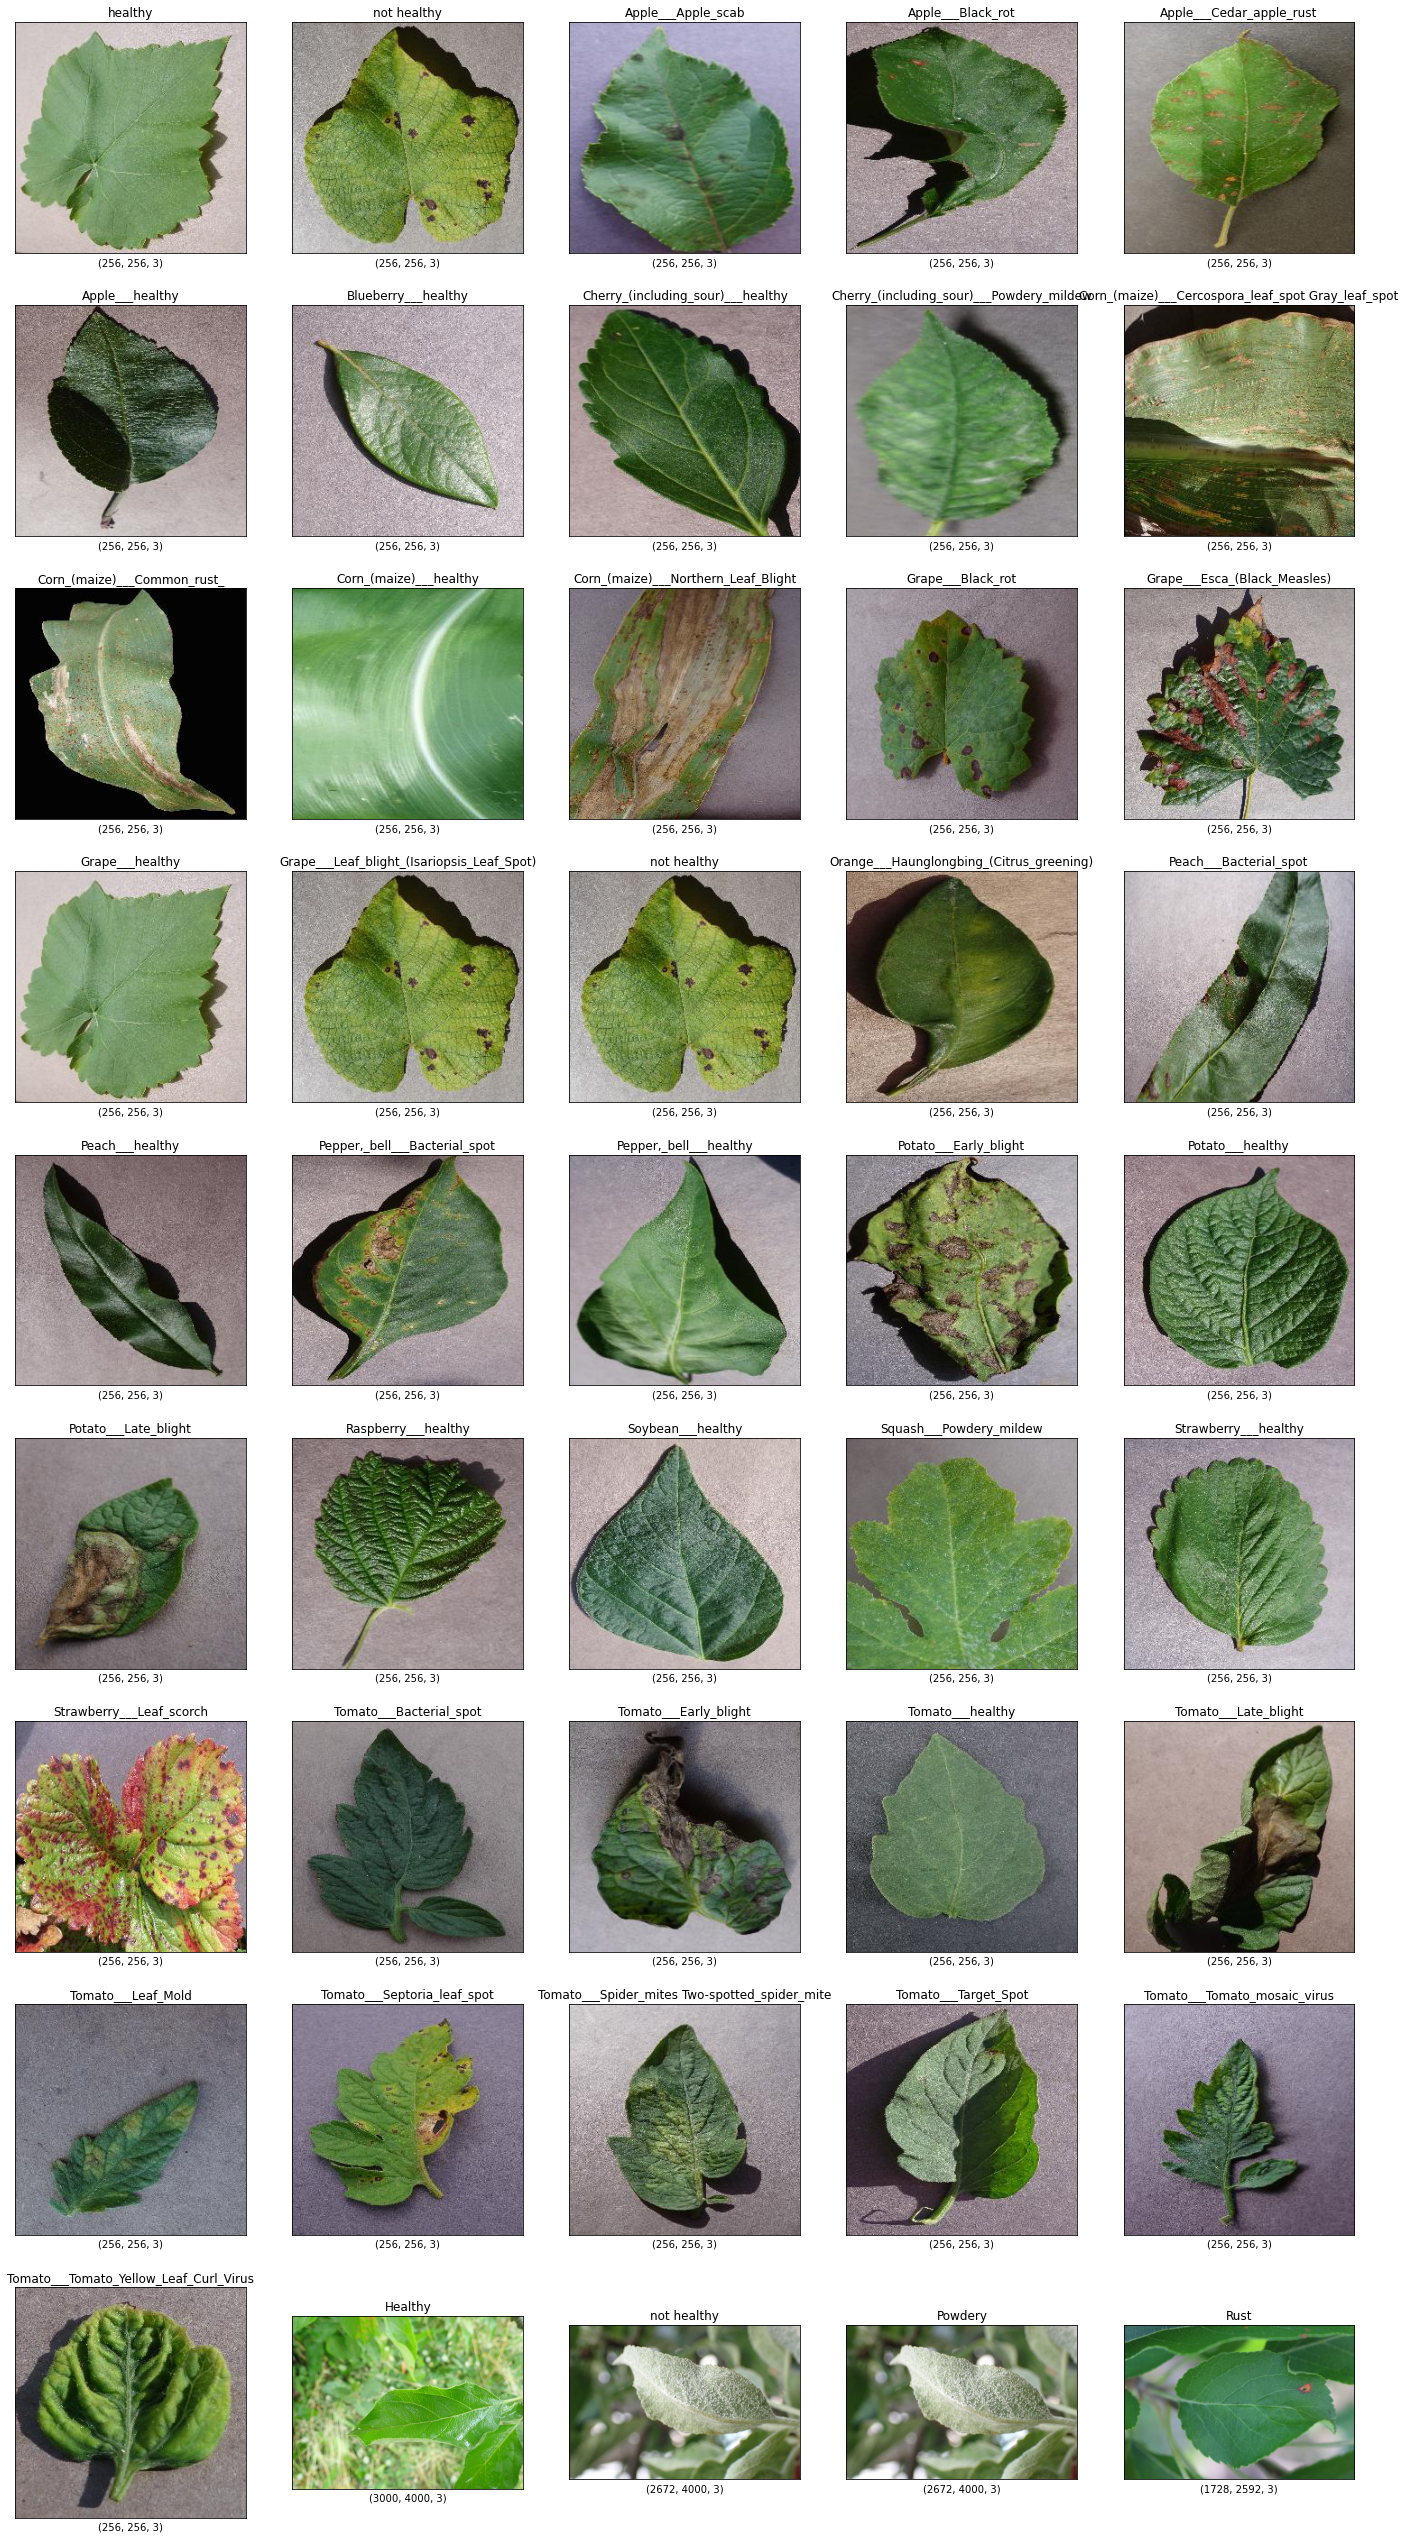

In [7]:
plt.figure(figsize=(24,46))

for row in range(len(image_names)//5):
    for col in range(5):
        index = (row*5)+col
        plt.subplot(9,5,index+1)
        plt.imshow(images_list[index])
        plt.title(image_names[index])
        plt.xlabel(str(images_list[index].shape))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

**To minimise the load of the machine and also the primary aim is to find the diseased crop before the disease spreads to other crops we will be having only two labels : healthy,not healthy (i.e binary classification model) so we will be combining all the different disease predicted dataset into not healthy category**

# Cleaning and Filtering the data

In [14]:
for dataset in os.listdir(root_path):
    dataset_path = root_path+"/"+dataset
    for folder in os.listdir(dataset_path):
        if folder == "test":continue
        data_path = dataset_path+"/"+folder+"/"
        labels_val = os.listdir(data_path)
        print(labels_val)
        for label in labels_val:
            os.makedirs(data_path+"not healthy", exist_ok = True) 
            os.makedirs(data_path+"healthy", exist_ok = True) 
            if label == "healthy" or label == "not healthy":continue
            print("-"*20)
            if label.lower().count("healthy") > 0:
                print(label,end= " ")
                print(data_path+label,data_path+"healthy")
                files = os.listdir(data_path+label)

                # Copy each file from the source directory to the destination directory
                for file in files:
                    source_path = os.path.join(data_path,label, file)
                    destination_path = data_path+"healthy/"+file
                    try:
                        shutil.copyfile(source_path, destination_path)
                    except shutil.SameFileError as e:
                        pass
                    except Exception as e:
                        print(e)
                    os.remove(source_path)
                os.rmdir(data_path+label)
            if label.lower().count("healthy") < 1:
                print(label,"not Healthy",end= " ")
                print(data_path+label,data_path+"not healthy")
                files = os.listdir(data_path+label)

                # Copy each file from the source directory to the destination directory
                for file in files:
                    source_path = os.path.join(data_path,label, file)
                    destination_path = data_path+"not healthy/"+file
                    try:
                        shutil.copyfile(source_path, destination_path)
                    except shutil.SameFileError as e:
                        pass
                    except Exception as e:
                        print(e)
                    os.remove(source_path)
                os.rmdir(data_path+label)
        print()

['not healthy', 'healthy']

['not healthy', 'healthy']

['not healthy', 'healthy']

['not healthy', 'healthy']

['not healthy', 'healthy']



In [6]:
def input_image_filter(data):
    return tf.map_fn(fn=lambda t: tf.image.resize(t,(224,224)), elems=data)

train_dataset,test_dataset,valid_dataset = None,None,None
for dataset in os.listdir(root_path):
    dataset_path = root_path+"/"+dataset
    for folder in os.listdir(dataset_path):
        data_path = dataset_path+"/"+folder
        labels_val = os.listdir(data_path)
        labels_val = ['not healthy','healthy']
        print(folder)
        datasets_val = keras.utils.image_dataset_from_directory(data_path,batch_size=100,shuffle=True,
                                                   labels="inferred",class_names=labels_val)
        
        if folder=="train":
            if train_dataset==None:train_dataset  = datasets_val
            else:
                print("updating train dataset")
                train_dataset = train_dataset.concatenate(datasets_val)
#             sizes = sum(list(map(lambda x : x[0].shape[0],train_dataset)))
#             print("Train data set : ",sizes)
        if folder=="valid":
            if valid_dataset == None:valid_dataset = datasets_val
            else:
                print("updating valid dataset")
                valid_dataset = valid_dataset.concatenate(datasets_val)
                
        
#             sizes = sum(list(map(lambda x : x[0].shape[0],valid_dataset)))
#             print("Valid dataset : ",sizes)
        if folder=="test":
            if test_dataset == None:test_dataset = datasets_val
            else:
                print("updating valid dataset")
                test_dataset = test_dataset.concatenate(datasets_val)
#         sizes = list(map(lambda x : x[0].shape,datasets_val))
#         print(sizes[:10])
        
        
        

valid
Found 60 files belonging to 2 classes.


2024-03-06 17:27:23.398618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 17:27:23.485391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-06 17:27:23.485715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

train
Found 1322 files belonging to 2 classes.
test
Found 150 files belonging to 2 classes.
train
Found 7462 files belonging to 2 classes.
updating train dataset
test
Found 1805 files belonging to 2 classes.
updating valid dataset
valid
Found 17572 files belonging to 2 classes.
updating valid dataset
train
Found 87819 files belonging to 2 classes.
updating train dataset
test
Found 33 files belonging to 2 classes.
updating valid dataset


In [7]:
def input_image_filter(data):
    print(data.shape)
    return tf.map_fn(fn=lambda t: tf.image.resize(t,(224,224)), elems=data)

train_dataset = train_dataset.map(lambda x,y : (input_image_filter(x),y))
valid_dataset = valid_dataset.map(lambda x,y : (input_image_filter(x),y))
test_dataset = test_dataset.map(lambda x,y : (input_image_filter(x),y))

(None, 256, 256, 3)
(None, 256, 256, 3)
(None, 256, 256, 3)


In [7]:
sizes = list(map(lambda x : x[0].shape,train_dataset))
sizes[:20]

[TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([22, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3]),
 TensorShape([100, 224, 224, 3])]

In [8]:
sum(list(map(lambda x: x[0],sizes)))

96603

2024-03-05 13:42:11.369297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


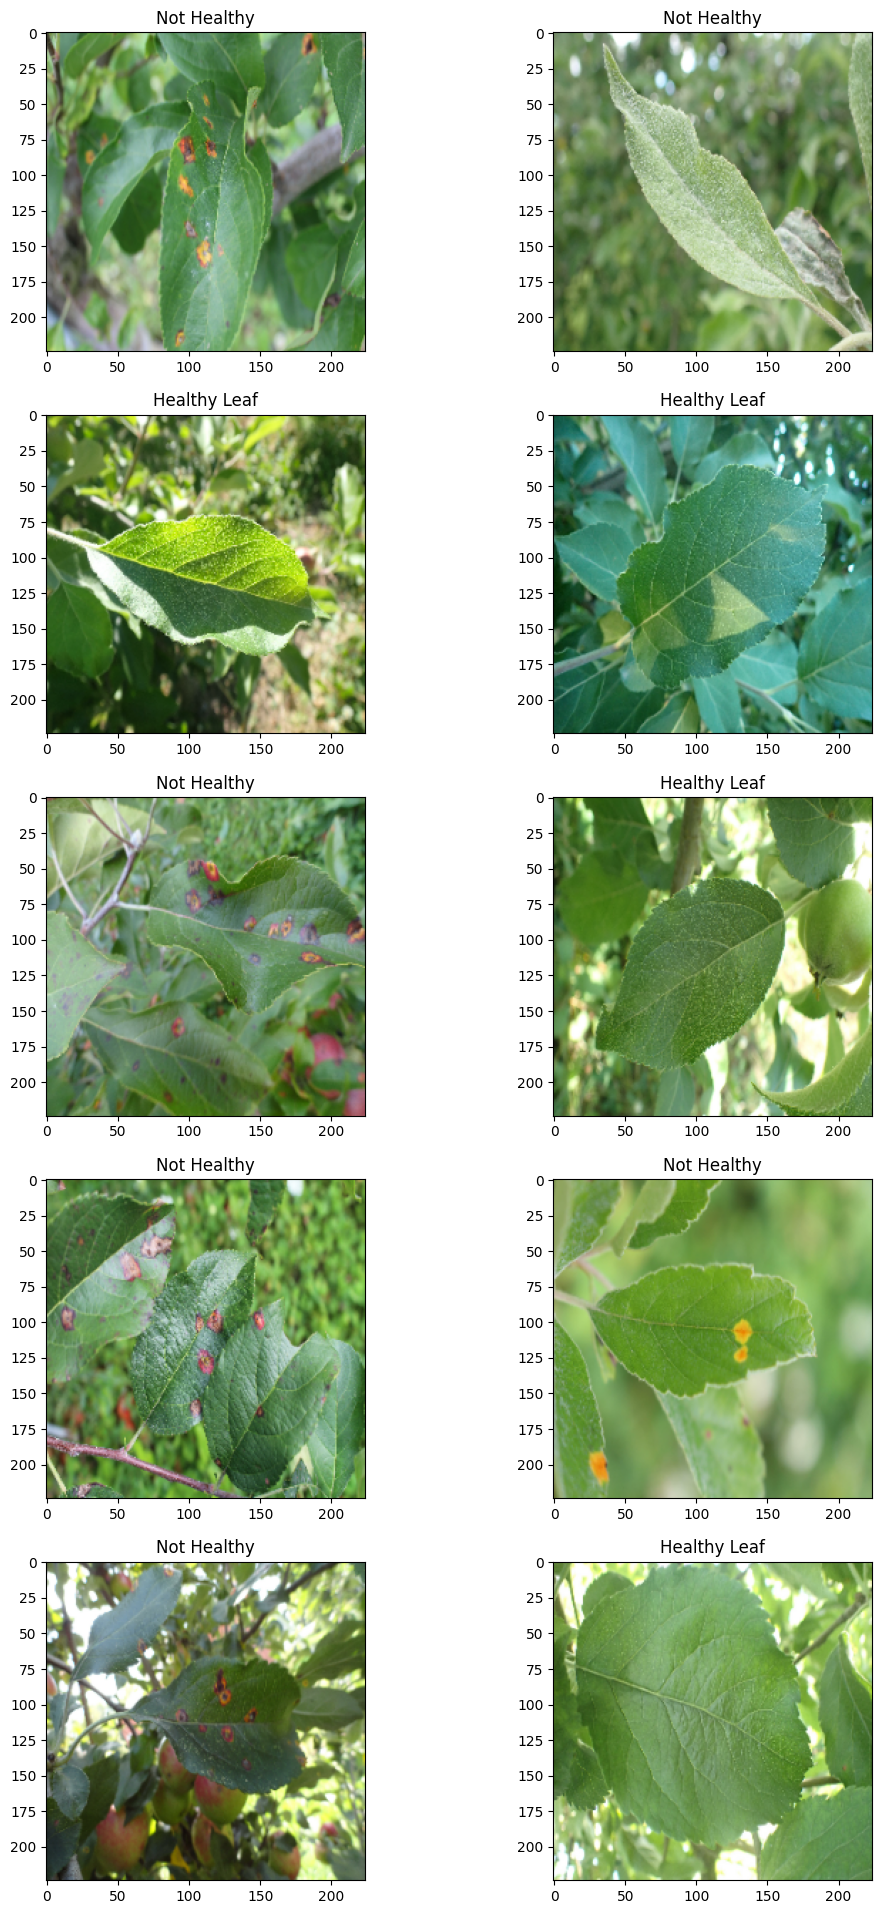

In [17]:
index = 1
row,col = 5,2
plt.figure(figsize=(12,24))
for data in train_dataset.take(row):
    for img in range(col):
        random_img_index = rd.randint(0,min(99,data[1].shape[0]))
        plt.subplot(row,col,index)
        plt.imshow(data[0][random_img_index].numpy().astype("uint8"))
        if data[1].numpy()[random_img_index] == 0:plt.title("Not Healthy")
        else:plt.title("Healthy Leaf")
        index+=1

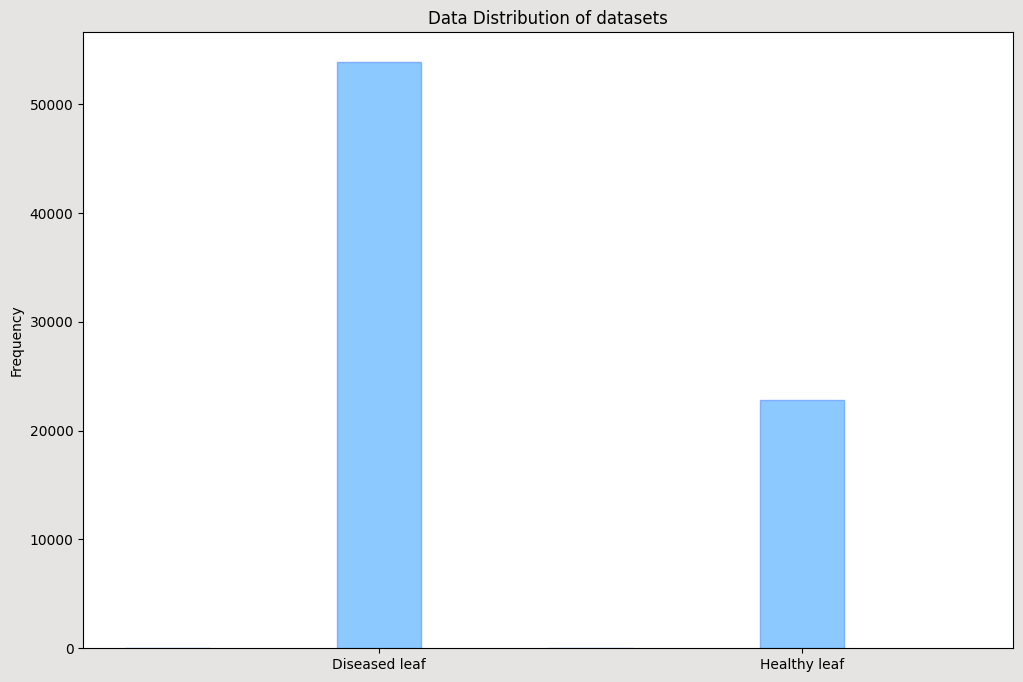

In [44]:
labels_dataset = train_dataset.map(lambda x, y: y)
labels_flat = tf.concat([labels for labels in labels_dataset], axis=0)
labels_np = labels_flat.numpy()

fig = plt.figure(figsize=(12,8))
plt.hist(labels_np, bins=np.arange(-0.5, 2, 0.5), alpha=0.7,color="#5CB3FF",width=0.2,align='mid',edgecolor='#6698FF')
fig.set_facecolor("#E5E4E2")
fig.set_edgecolor("#56A5EC")
plt.grid(axis='y', alpha=0.75)
plt.xticks([0.1,1.1],['Diseased leaf','Healthy leaf'])
plt.ylabel('Frequency')
plt.title('Data Distribution of datasets')
plt.grid(False)
plt.show()

In [43]:
for dataset in os.listdir(root_path):
    dataset_path = root_path+"/"+dataset+"/"
    for folder in os.listdir(dataset_path):
        print(folder,"Started")
        if folder != "train":continue
        for label in os.listdir(dataset_path+folder):
            index =0
            files_list = os.listdir(os.path.join(dataset_path,folder,label))
            if label != 'healthy':continue
            for img in files_list:
                if index%1 == 0:
                    print(index,end=' ')
                augmented_image = tf.io.read_file(dataset_path+folder+"/"+label+"/"+img)
                augmented_image = tf.image.decode_jpeg(augmented_image, channels=3)  # Assuming RGB image
                augmented_image = tf.image.random_flip_left_right(augmented_image)
                augmented_image = tf.image.random_flip_up_down(augmented_image)
                augmented_image = tf.clip_by_value(augmented_image, 0, 255)  # Clip values to [0, 255]

                # Convert image back to uint8 format
                augmented_image = tf.cast(augmented_image, tf.uint8)


                tf.io.write_file(os.path.join(data_path,folder,label,img.split(".")[0]+"_aug.jpg"), tf.image.encode_jpeg(augmented_image))

valid Started
train Started
test Started
train Started
test Started
valid Started
train Started
test Started


In [42]:
labels_dataset = train_dataset.map(lambda x, y: y)
labels_flat = tf.concat([labels for labels in labels_dataset], axis=0)
labels_np = labels_flat.numpy()

2024-03-06 14:35:14.804633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-06 14:35:19.129833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


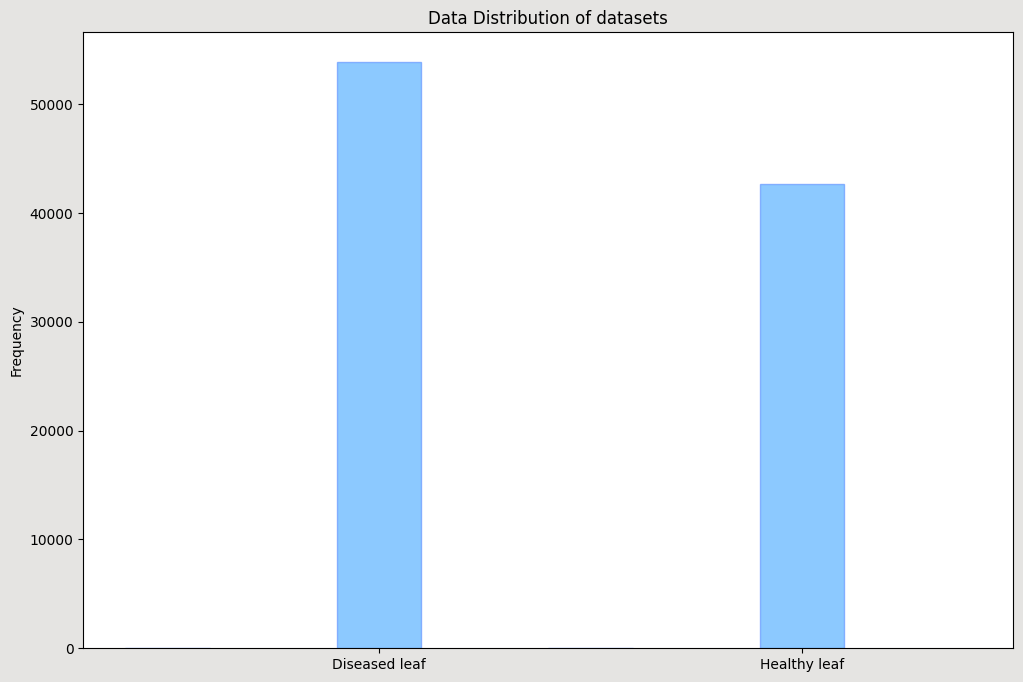

In [38]:
fig = plt.figure(figsize=(12,8))
plt.hist(labels_np, bins=np.arange(-0.5, 2, 0.5), alpha=0.7,color="#5CB3FF",width=0.2,align='mid',edgecolor='#6698FF')
fig.set_facecolor("#E5E4E2")
fig.set_edgecolor("#56A5EC")
plt.grid(axis='y', alpha=0.75)
plt.xticks([0.1,1.1],['Diseased leaf','Healthy leaf'])
plt.ylabel('Frequency')
plt.title('Data Distribution of datasets')
plt.grid(False)
plt.show()

In [8]:
len(train_dataset),len(valid_dataset),len(test_dataset)

(968, 177, 22)

# Model Training :
- We are going to build a neural network which has 5 layers

In [8]:
model = keras.models.Sequential([
    keras.layers.Input((224,224,3)),
    keras.layers.MaxPooling2D(pool_size=2), 
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=2, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d (MaxPooling2  (None, 112, 112, 3)       0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 112, 112, 32)      128       
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 dense_1 (Dense)             (None, 112, 112, 64)      2112      
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 dense_2 (Dense)             (None, 112, 112, 32)      2080      
                                                        

In [14]:
for data in train_dataset:
    print(data[0][0].shape)
    break

(224, 224, 3)


In [9]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_dataset.take(100),validation_data=valid_dataset.take(50),epochs=25)

Epoch 1/25


2024-03-06 17:27:40.609973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-06 17:27:44.575775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-06 17:27:46.145651: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fea6077d930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 17:27:46.146339: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1709726266.259326    6272 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 21s 144ms/step - loss: 355718049824768.0000 - accuracy: 0.6993 - val_loss: 0.8225 - val_accuracy: 0.3173
Epoch 2/25
  8/100 [=>............................] - ETA: 26s - loss: 0.6996 - accuracy: 0.5362

2024-03-06 17:28:06.453657: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 79/100 [======================>.......] - ETA: 2s - loss: 0.5974 - accuracy: 0.7121

2024-03-06 17:28:13.556066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 156ms/step - loss: 0.6087 - accuracy: 0.6944 - val_loss: 0.7990 - val_accuracy: 0.3155
Epoch 3/25
  7/100 [=>............................] - ETA: 29s - loss: 0.7037 - accuracy: 0.5086

2024-03-06 17:28:25.215026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5930 - accuracy: 0.7142

2024-03-06 17:28:32.425731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6064 - accuracy: 0.6925 - val_loss: 0.7293 - val_accuracy: 0.3159
Epoch 4/25
  8/100 [=>............................] - ETA: 26s - loss: 0.6628 - accuracy: 0.5875

2024-03-06 17:28:44.089798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 80/100 [=======================>......] - ETA: 2s - loss: 0.5945 - accuracy: 0.7171

2024-03-06 17:28:51.310107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 154ms/step - loss: 0.6082 - accuracy: 0.6974 - val_loss: 0.7844 - val_accuracy: 0.3135
Epoch 5/25
  8/100 [=>............................] - ETA: 25s - loss: 0.6813 - accuracy: 0.5450

2024-03-06 17:29:02.718117: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 80/100 [=======================>......] - ETA: 2s - loss: 0.5943 - accuracy: 0.7137

2024-03-06 17:29:09.807735: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 156ms/step - loss: 0.6093 - accuracy: 0.6901 - val_loss: 0.7614 - val_accuracy: 0.3147
Epoch 6/25
 83/100 [=======================>......] - ETA: 1s - loss: 0.5922 - accuracy: 0.7189

2024-03-06 17:29:28.673009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 154ms/step - loss: 0.6065 - accuracy: 0.6930 - val_loss: 0.7180 - val_accuracy: 0.3139
Epoch 7/25
  7/100 [=>............................] - ETA: 30s - loss: 0.6703 - accuracy: 0.6171

2024-03-06 17:29:39.995833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 79/100 [======================>.......] - ETA: 2s - loss: 0.5949 - accuracy: 0.7209

2024-03-06 17:29:47.061628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6088 - accuracy: 0.6989 - val_loss: 0.7848 - val_accuracy: 0.3155
Epoch 8/25
  7/100 [=>............................] - ETA: 30s - loss: 0.6992 - accuracy: 0.5629

2024-03-06 17:29:59.113293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5925 - accuracy: 0.7206

2024-03-06 17:30:06.354265: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6097 - accuracy: 0.6924 - val_loss: 0.7295 - val_accuracy: 0.3117
Epoch 9/25
  8/100 [=>............................] - ETA: 26s - loss: 0.6684 - accuracy: 0.6200

2024-03-06 17:30:18.427785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5921 - accuracy: 0.7243

2024-03-06 17:30:25.727962: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6053 - accuracy: 0.6993 - val_loss: 0.7040 - val_accuracy: 0.3123
Epoch 10/25
  8/100 [=>............................] - ETA: 26s - loss: 0.6545 - accuracy: 0.6388

2024-03-06 17:30:37.248479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 80/100 [=======================>......] - ETA: 2s - loss: 0.5917 - accuracy: 0.7230

2024-03-06 17:30:44.609785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 162ms/step - loss: 0.6042 - accuracy: 0.7025 - val_loss: 0.8205 - val_accuracy: 0.3139
Epoch 11/25
  8/100 [=>............................] - ETA: 29s - loss: 0.6954 - accuracy: 0.5238

2024-03-06 17:30:57.137382: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5958 - accuracy: 0.7119

2024-03-06 17:31:04.596968: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 20s 163ms/step - loss: 0.6086 - accuracy: 0.6944 - val_loss: 0.7714 - val_accuracy: 0.3163
Epoch 12/25
  7/100 [=>............................] - ETA: 30s - loss: 0.6982 - accuracy: 0.5643

2024-03-06 17:31:16.534268: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5944 - accuracy: 0.7191

2024-03-06 17:31:23.970395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6978

2024-03-06 17:31:26.327136: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 159ms/step - loss: 0.6070 - accuracy: 0.6978 - val_loss: 0.7439 - val_accuracy: 0.3175
Epoch 13/25
  9/100 [=>............................] - ETA: 22s - loss: 0.6797 - accuracy: 0.5956

2024-03-06 17:31:35.671788: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5941 - accuracy: 0.7192

2024-03-06 17:31:42.941924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.6966

2024-03-06 17:31:45.185479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 156ms/step - loss: 0.6062 - accuracy: 0.6966 - val_loss: 0.7161 - val_accuracy: 0.3127
Epoch 14/25
  9/100 [=>............................] - ETA: 23s - loss: 0.6680 - accuracy: 0.6078

2024-03-06 17:31:54.541346: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 83/100 [=======================>......] - ETA: 1s - loss: 0.5921 - accuracy: 0.7226

2024-03-06 17:32:01.854942: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7007

2024-03-06 17:32:04.068103: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 156ms/step - loss: 0.6042 - accuracy: 0.7007 - val_loss: 0.7294 - val_accuracy: 0.3155
Epoch 15/25
  8/100 [=>............................] - ETA: 25s - loss: 0.6617 - accuracy: 0.5838

2024-03-06 17:32:13.434924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5906 - accuracy: 0.7204

2024-03-06 17:32:20.754181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.6954

2024-03-06 17:32:22.982353: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6055 - accuracy: 0.6954 - val_loss: 0.7249 - val_accuracy: 0.3149
Epoch 16/25
  8/100 [=>............................] - ETA: 25s - loss: 0.6608 - accuracy: 0.5838

2024-03-06 17:32:32.324520: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5903 - accuracy: 0.7189

2024-03-06 17:32:39.587830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.6955

2024-03-06 17:32:41.809653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6039 - accuracy: 0.6955 - val_loss: 0.7273 - val_accuracy: 0.3163
Epoch 17/25
  9/100 [=>............................] - ETA: 22s - loss: 0.6679 - accuracy: 0.6022

2024-03-06 17:32:51.215576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5917 - accuracy: 0.7198

2024-03-06 17:32:58.485216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7027

2024-03-06 17:33:00.727581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 156ms/step - loss: 0.6031 - accuracy: 0.7027 - val_loss: 0.7788 - val_accuracy: 0.3192
Epoch 18/25
  7/100 [=>............................] - ETA: 29s - loss: 0.6973 - accuracy: 0.5357

2024-03-06 17:33:10.127854: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5949 - accuracy: 0.7146

2024-03-06 17:33:17.581314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.6950

2024-03-06 17:33:19.820383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 159ms/step - loss: 0.6076 - accuracy: 0.6950 - val_loss: 0.7815 - val_accuracy: 0.3147
Epoch 19/25
  8/100 [=>............................] - ETA: 27s - loss: 0.6964 - accuracy: 0.5575

2024-03-06 17:33:29.314036: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5937 - accuracy: 0.7169

2024-03-06 17:33:36.694536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.6927

2024-03-06 17:33:38.948857: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 159ms/step - loss: 0.6097 - accuracy: 0.6927 - val_loss: 0.7540 - val_accuracy: 0.3171
Epoch 20/25
  7/100 [=>............................] - ETA: 30s - loss: 0.6894 - accuracy: 0.5671

2024-03-06 17:33:48.434868: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5966 - accuracy: 0.7178

2024-03-06 17:33:55.887642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 160ms/step - loss: 0.6080 - accuracy: 0.6975 - val_loss: 0.7352 - val_accuracy: 0.3151
Epoch 21/25
  9/100 [=>............................] - ETA: 23s - loss: 0.6808 - accuracy: 0.5900

2024-03-06 17:34:07.684148: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5878 - accuracy: 0.7220

2024-03-06 17:34:14.918042: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6031 - accuracy: 0.6978 - val_loss: 0.7180 - val_accuracy: 0.3175
Epoch 22/25
  8/100 [=>............................] - ETA: 26s - loss: 0.6630 - accuracy: 0.6100

2024-03-06 17:34:26.732349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5908 - accuracy: 0.7213

2024-03-06 17:34:34.090193: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.6965

2024-03-06 17:34:36.436509: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 159ms/step - loss: 0.6041 - accuracy: 0.6965 - val_loss: 0.7237 - val_accuracy: 0.3127
Epoch 23/25
  9/100 [=>............................] - ETA: 23s - loss: 0.6608 - accuracy: 0.6133

2024-03-06 17:34:45.825064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5872 - accuracy: 0.7236

2024-03-06 17:34:53.077058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6976

2024-03-06 17:34:55.376417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6022 - accuracy: 0.6976 - val_loss: 0.7239 - val_accuracy: 0.3135
Epoch 24/25
  7/100 [=>............................] - ETA: 29s - loss: 0.6767 - accuracy: 0.6071

2024-03-06 17:35:04.902608: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 82/100 [=======================>......] - ETA: 2s - loss: 0.5967 - accuracy: 0.7198

2024-03-06 17:35:12.274699: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6085 - accuracy: 0.6980 - val_loss: 0.7490 - val_accuracy: 0.3147
Epoch 25/25
  9/100 [=>............................] - ETA: 23s - loss: 0.6814 - accuracy: 0.5789

2024-03-06 17:35:23.863877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 81/100 [=======================>......] - ETA: 2s - loss: 0.5908 - accuracy: 0.7184

2024-03-06 17:35:31.083300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/100 [==============================] - 19s 157ms/step - loss: 0.6041 - accuracy: 0.6968 - val_loss: 0.7368 - val_accuracy: 0.3181


Text(0.5, 0.98, 'Training the simple  model with 200 batch')

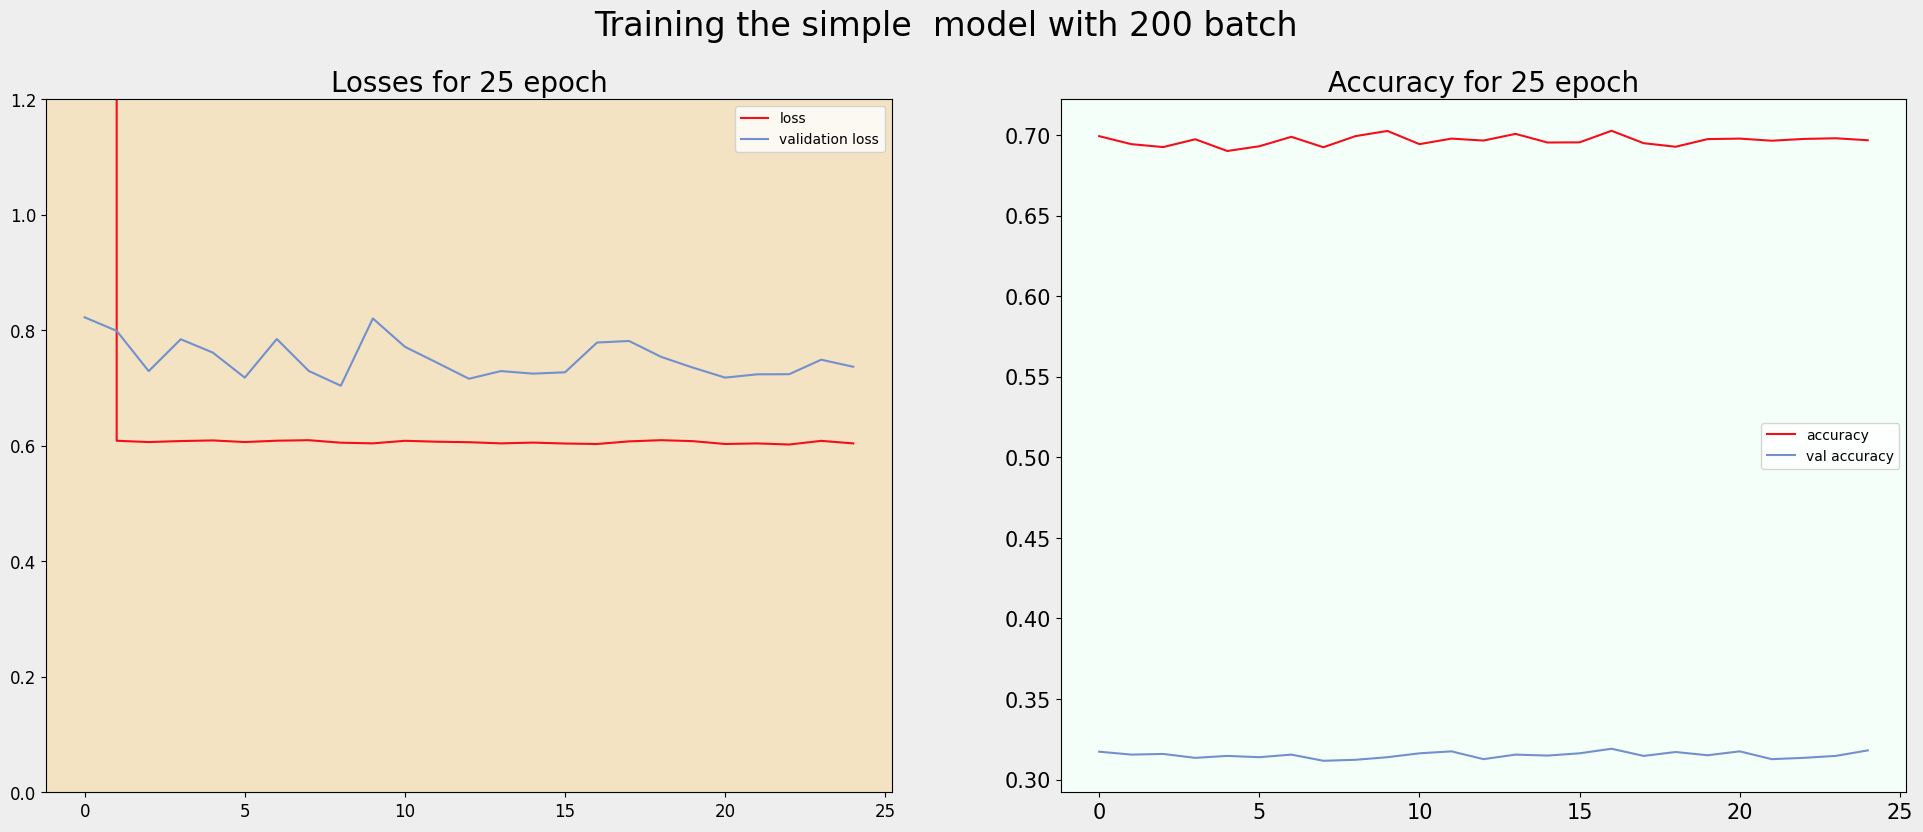

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
fig.set_facecolor("#EEEEEE")


ax1.plot(range(len(history.history['loss'])),history.history['loss'],color='#F70D1A',label='loss')
ax1.set_title("Losses for 25 epoch",fontdict={"size":20})
ax1.set_facecolor("#F3E3C3")
ax1.tick_params(axis='x', labelsize=12)  
ax1.tick_params(axis='y', labelsize=12)  
ax1.set_ylim((0,1.2))
ax1.plot(range(len(history.history['val_loss'])),history.history['val_loss'],color='#728FCE',label='validation loss')
ax1.legend()

ax2.plot(range(len(history.history['accuracy'])),history.history['accuracy'],color='#F70D1A',label='accuracy')
ax2.set_title("Accuracy for 25 epoch",fontdict={"size":20})
ax2.set_facecolor("#F5FFFA")
ax2.tick_params(axis='x', labelsize=15)  
ax2.tick_params(axis='y', labelsize=15)  

ax2.plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'],color='#728FCE',label='val accuracy')
ax2.legend()
plt.suptitle("Training the simple  model with 200 batch",fontsize="24")

In [18]:
model_evaluation = []
for data in test_dataset.take(20):
    predictions = model.evaluate(data[0],data[1])
    model_evaluation.append(predictions)

1/4 [======>.......................] - ETA: 0s - loss: 0.7314 - accuracy: 0.3438

2024-03-06 17:38:25.229410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 [==============================] - 0s 10ms/step - loss: 0.7574 - accuracy: 0.2200


2024-03-06 17:38:26.980827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952388 bytes after encountering the first element of size 25952388 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 [==============================] - 0s 10ms/step - loss: 0.7490 - accuracy: 0.2600


In [19]:
np.array(list(map(lambda x : x[0],model_evaluation))).mean(),np.array(list(map(lambda x : x[1],model_evaluation))).mean()

(0.7526956021785736, 0.24249999821186066)

In [23]:
model.save("self_model.h5")

/home/jeswin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Base model :
- We are doing transfer learning from already existing model

In [8]:
base_model = keras.models.load_model("RESNET50_PLANT_DISEASE.h5")
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

# Train the RESNET model :

In [18]:
model = keras.models.load_model("tuned_resnet.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [25]:
for layers in model.layers:
    layers.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [26]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history_list = []
for data in train_dataset.take(100):
    history = model.fit(x=data[0],y=data[1],validation_data=new_valid.take(5),epochs=1)
    history_list.append(history)

4/4 [==============================] - 20s 6s/step - loss: 0.7608 - accuracy: 0.3700 - val_loss: 0.6487 - val_accuracy: 0.7100


In [28]:
history_list[0].history

{'loss': [1.1686179637908936],
 'accuracy': [0.7099999785423279],
 'val_loss': [0.8215646743774414],
 'val_accuracy': [0.7099999785423279]}

In [29]:
history_loss = list(map(lambda x:x.history, history_list))
history_loss[0]

{'loss': [1.1686179637908936],
 'accuracy': [0.7099999785423279],
 'val_loss': [0.8215646743774414],
 'val_accuracy': [0.7099999785423279]}

In [30]:
file = open('training_loss_100_epoch.txt','w')
file.write(str(history_loss))
file.close() 

In [32]:
dir(history_list[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [35]:
history_list[0].params

{'verbose': 1, 'epochs': 1, 'steps': 4}

In [36]:
model.save('trained_binary_model.h5')

D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model = keras.models.load_model("trained_binary_model.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [17]:
model_evaluations = []
for data in test_dataset.take(20):
    predictions = model.evaluate(data[0],data[1])
    model_evaluations.append(predictions)

2024-03-06 11:52:21.725851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/4 [==============>...............] - ETA: 0s - loss: 0.6426 - accuracy: 0.7344

2024-03-06 11:52:24.112464: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25952388 bytes after encountering the first element of size 25952388 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 [==============================] - 0s 52ms/step - loss: 0.6239 - accuracy: 0.8100


In [19]:
model_evaluations

[[0.653664767742157, 0.6899999976158142],
 [0.6710416674613953, 0.6200000047683716],
 [0.636288046836853, 0.7599999904632568],
 [0.6338056325912476, 0.7699999809265137],
 [0.6412528157234192, 0.7400000095367432],
 [0.6462176442146301, 0.7200000286102295],
 [0.6486999988555908, 0.7099999785423279],
 [0.6437351703643799, 0.7300000190734863],
 [0.6288408041000366, 0.7900000214576721],
 [0.6313232779502869, 0.7799999713897705],
 [0.6462176442146301, 0.7200000286102295],
 [0.6288408637046814, 0.7900000214576721],
 [0.6387704610824585, 0.75],
 [0.6238760352134705, 0.8100000023841858],
 [0.636288046836853, 0.7599999904632568],
 [0.6387704610824585, 0.75],
 [0.6238760948181152, 0.8100000023841858],
 [0.6338056325912476, 0.7699999809265137],
 [0.6238760352134705, 0.8100000023841858],
 [0.6238760352134705, 0.8100000023841858]]

In [18]:
np.array(list(map(lambda x : x[0],model_evaluations))).mean(),np.array(list(map(lambda x : x[1],model_evaluations))).mean()

(0.6376533567905426, 0.75450000166893)

# Replacing the last layer with two neurons :

In [ ]:
new_output = keras.layers.Dense(2, activation='softmax',name='dense_3')(base_model.layers[-2].output)
new_model = keras.models.Model(inputs=base_model.input, outputs=new_output)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
for layer in new_model.layers[:-1]:
    layer.trainable = False
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
for layer in new_model.layers[:-1]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = new_model.fit(train_dataset.take(200),epochs=25)
# history_list =[]
# index =0
# for data in train_datasetasetaset.take(500):
#     print(index,"Started")
#     history = new_model.fit(x=data[0],y=data[1],epochs=1)
#     history_list.append(history)
#     index+=1

Epoch 1/25


2024-03-05 16:34:56.831182: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-05 16:34:57.301035: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 16:34:58.371603: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  1/200 [..............................] - ETA: 36:30 - loss: 2.7926 - accuracy: 0.3600

2024-03-05 16:35:02.246366: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f276d65afa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 16:35:02.246387: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1709636702.307865   58042 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 80/200 [===========>..................] - ETA: 29s - loss: 6.0255 - accuracy: 0.9311

2024-03-05 16:35:21.949521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 62s 256ms/step - loss: 4.3120 - accuracy: 0.9423
Epoch 2/25
  6/200 [..............................] - ETA: 1:11 - loss: 12.0644 - accuracy: 0.8233

2024-03-05 16:35:58.763418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 2.4408 - accuracy: 0.9590

2024-03-05 16:36:14.700450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 243ms/step - loss: 2.4039 - accuracy: 0.9567
Epoch 3/25


2024-03-05 16:36:48.666766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:09 - loss: 8.1939 - accuracy: 0.8517

2024-03-05 16:36:50.729058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.9239 - accuracy: 0.9619

2024-03-05 16:37:06.659294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 243ms/step - loss: 1.6282 - accuracy: 0.9623
Epoch 4/25


2024-03-05 16:37:40.601874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:10 - loss: 6.7717 - accuracy: 0.8467

2024-03-05 16:37:42.669851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.2495 - accuracy: 0.9668

2024-03-05 16:37:58.696388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 244ms/step - loss: 1.0857 - accuracy: 0.9640
Epoch 5/25


2024-03-05 16:38:32.702992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:10 - loss: 5.3698 - accuracy: 0.8283

2024-03-05 16:38:34.783326: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 0.9128 - accuracy: 0.9657

2024-03-05 16:38:50.829586: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 243ms/step - loss: 0.9561 - accuracy: 0.9623
Epoch 6/25


2024-03-05 16:39:24.814185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:14 - loss: 3.8662 - accuracy: 0.8450

2024-03-05 16:39:26.926247: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 0.7913 - accuracy: 0.9654

2024-03-05 16:39:43.062458: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 244ms/step - loss: 1.0417 - accuracy: 0.9596
Epoch 7/25


2024-03-05 16:40:17.066225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:13 - loss: 4.4241 - accuracy: 0.8517

2024-03-05 16:40:19.225201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.3118 - accuracy: 0.9586

2024-03-05 16:40:35.272406: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 245ms/step - loss: 1.2022 - accuracy: 0.9613
Epoch 8/25


2024-03-05 16:41:09.577226: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:11 - loss: 4.6200 - accuracy: 0.8583

2024-03-05 16:41:11.559527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.2300 - accuracy: 0.9646

2024-03-05 16:41:27.725079: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 245ms/step - loss: 0.9723 - accuracy: 0.9637
Epoch 9/25


2024-03-05 16:42:01.956572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:10 - loss: 2.7453 - accuracy: 0.8850

2024-03-05 16:42:04.046029: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.2389 - accuracy: 0.9585

2024-03-05 16:42:20.157091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 52s 245ms/step - loss: 1.9940 - accuracy: 0.9586
Epoch 10/25


2024-03-05 16:42:54.559436: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:11 - loss: 8.8244 - accuracy: 0.8150

2024-03-05 16:42:56.540957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 1.7597 - accuracy: 0.9607

2024-03-05 16:43:12.750636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 53s 246ms/step - loss: 1.3386 - accuracy: 0.9626
Epoch 11/25


2024-03-05 16:43:47.042318: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:12 - loss: 4.4623 - accuracy: 0.8467

2024-03-05 16:43:49.148827: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 0.9081 - accuracy: 0.9668

2024-03-05 16:44:05.321149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 53s 246ms/step - loss: 0.9724 - accuracy: 0.9646
Epoch 12/25


2024-03-05 16:44:39.663242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 1:10 - loss: 4.0184 - accuracy: 0.8350

2024-03-05 16:44:41.766435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 31s - loss: 0.6880 - accuracy: 0.9684

2024-03-05 16:44:57.986462: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 51s 239ms/step - loss: 1.0681 - accuracy: 0.9600
Epoch 13/25


2024-03-05 16:45:30.413266: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 6.0923 - accuracy: 0.8283 

2024-03-05 16:45:32.067714: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.7723 - accuracy: 0.9547

2024-03-05 16:45:47.321186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 232ms/step - loss: 2.2310 - accuracy: 0.9557
Epoch 14/25
  6/200 [..............................] - ETA: 58s - loss: 8.2829 - accuracy: 0.8250 

2024-03-05 16:46:21.199738: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 87/200 [============>.................] - ETA: 25s - loss: 1.1070 - accuracy: 0.9717

2024-03-05 16:46:38.740821: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 48s 225ms/step - loss: 1.1332 - accuracy: 0.9642
Epoch 15/25


2024-03-05 16:47:07.347519: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 59s - loss: 5.3921 - accuracy: 0.8183 

2024-03-05 16:47:08.957253: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.1044 - accuracy: 0.9634

2024-03-05 16:47:24.187418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 0.9848 - accuracy: 0.9626
Epoch 16/25


2024-03-05 16:47:56.250544: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 4.1309 - accuracy: 0.8667 

2024-03-05 16:47:57.868465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.8432 - accuracy: 0.9650

2024-03-05 16:48:13.134218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 0.9167 - accuracy: 0.9624
Epoch 17/25


2024-03-05 16:48:45.321928: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 5.3011 - accuracy: 0.8283 

2024-03-05 16:48:46.926363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.8673 - accuracy: 0.9659

2024-03-05 16:49:02.163991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 1.1099 - accuracy: 0.9619
Epoch 18/25


2024-03-05 16:49:34.303968: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 57s - loss: 4.4724 - accuracy: 0.8317 

2024-03-05 16:49:35.943539: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.7662 - accuracy: 0.9659

2024-03-05 16:49:51.198643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 1.2276 - accuracy: 0.9621
Epoch 19/25


2024-03-05 16:50:23.287733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 5.3020 - accuracy: 0.8117 

2024-03-05 16:50:24.910633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.9175 - accuracy: 0.9650

2024-03-05 16:50:40.202308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 0.8767 - accuracy: 0.9629
Epoch 20/25


2024-03-05 16:51:12.340188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 3.3767 - accuracy: 0.8533 

2024-03-05 16:51:13.985811: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.0905 - accuracy: 0.9601

2024-03-05 16:51:29.238835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 1.6414 - accuracy: 0.9563
Epoch 21/25


2024-03-05 16:52:01.473864: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 5.6234 - accuracy: 0.8450 

2024-03-05 16:52:03.126662: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.3196 - accuracy: 0.9605

2024-03-05 16:52:18.390381: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 1.3931 - accuracy: 0.9623
Epoch 22/25


2024-03-05 16:52:50.471651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 57s - loss: 4.4421 - accuracy: 0.8383

2024-03-05 16:52:52.108733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.9761 - accuracy: 0.9632

2024-03-05 16:53:07.310982: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 230ms/step - loss: 1.2365 - accuracy: 0.9597
Epoch 23/25


2024-03-05 16:53:39.410274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 6.3693 - accuracy: 0.8217 

2024-03-05 16:53:41.070471: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.2156 - accuracy: 0.9625

2024-03-05 16:53:56.328082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 230ms/step - loss: 0.9300 - accuracy: 0.9653
Epoch 24/25


2024-03-05 16:54:28.372137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 59s - loss: 4.4387 - accuracy: 0.8400 

2024-03-05 16:54:30.033415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 0.9847 - accuracy: 0.9636

2024-03-05 16:54:45.221311: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 230ms/step - loss: 1.4162 - accuracy: 0.9593
Epoch 25/25


2024-03-05 16:55:17.295113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  6/200 [..............................] - ETA: 58s - loss: 7.7481 - accuracy: 0.8033 

2024-03-05 16:55:18.944418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 73/200 [=========>....................] - ETA: 29s - loss: 1.4232 - accuracy: 0.9604

2024-03-05 16:55:34.150614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


200/200 [==============================] - 49s 231ms/step - loss: 1.2809 - accuracy: 0.9618


In [ ]:
history.history

{'loss': [4.3119797706604,
  2.403853416442871,
  1.6282436847686768,
  1.0856852531433105,
  0.9560980200767517,
  1.0416650772094727,
  1.2021677494049072,
  0.9722549915313721,
  1.9940478801727295,
  1.3385504484176636,
  0.9723575711250305,
  1.0681331157684326,
  2.231015682220459,
  1.1331613063812256,
  0.9848251938819885,
  0.9166976809501648,
  1.109870433807373,
  1.2276177406311035,
  0.8766876459121704,
  1.6413846015930176,
  1.3931317329406738,
  1.2364693880081177,
  0.9299785494804382,
  1.4162375926971436,
  1.2809232473373413],
 'accuracy': [0.9423154592514038,
  0.9567491412162781,
  0.9623315334320068,
  0.9639911651611328,
  0.9622812271118164,
  0.9596157670021057,
  0.9612753987312317,
  0.9637396931648254,
  0.9585596323013306,
  0.9625830054283142,
  0.9645946621894836,
  0.9600180983543396,
  0.9556930065155029,
  0.9642425775527954,
  0.9626332521438599,
  0.9624320864677429,
  0.961929202079773,
  0.9620800614356995,
  0.9628847241401672,
  0.95634680986404

Text(0.5, 0.98, 'Training the last layer with 200 batch')

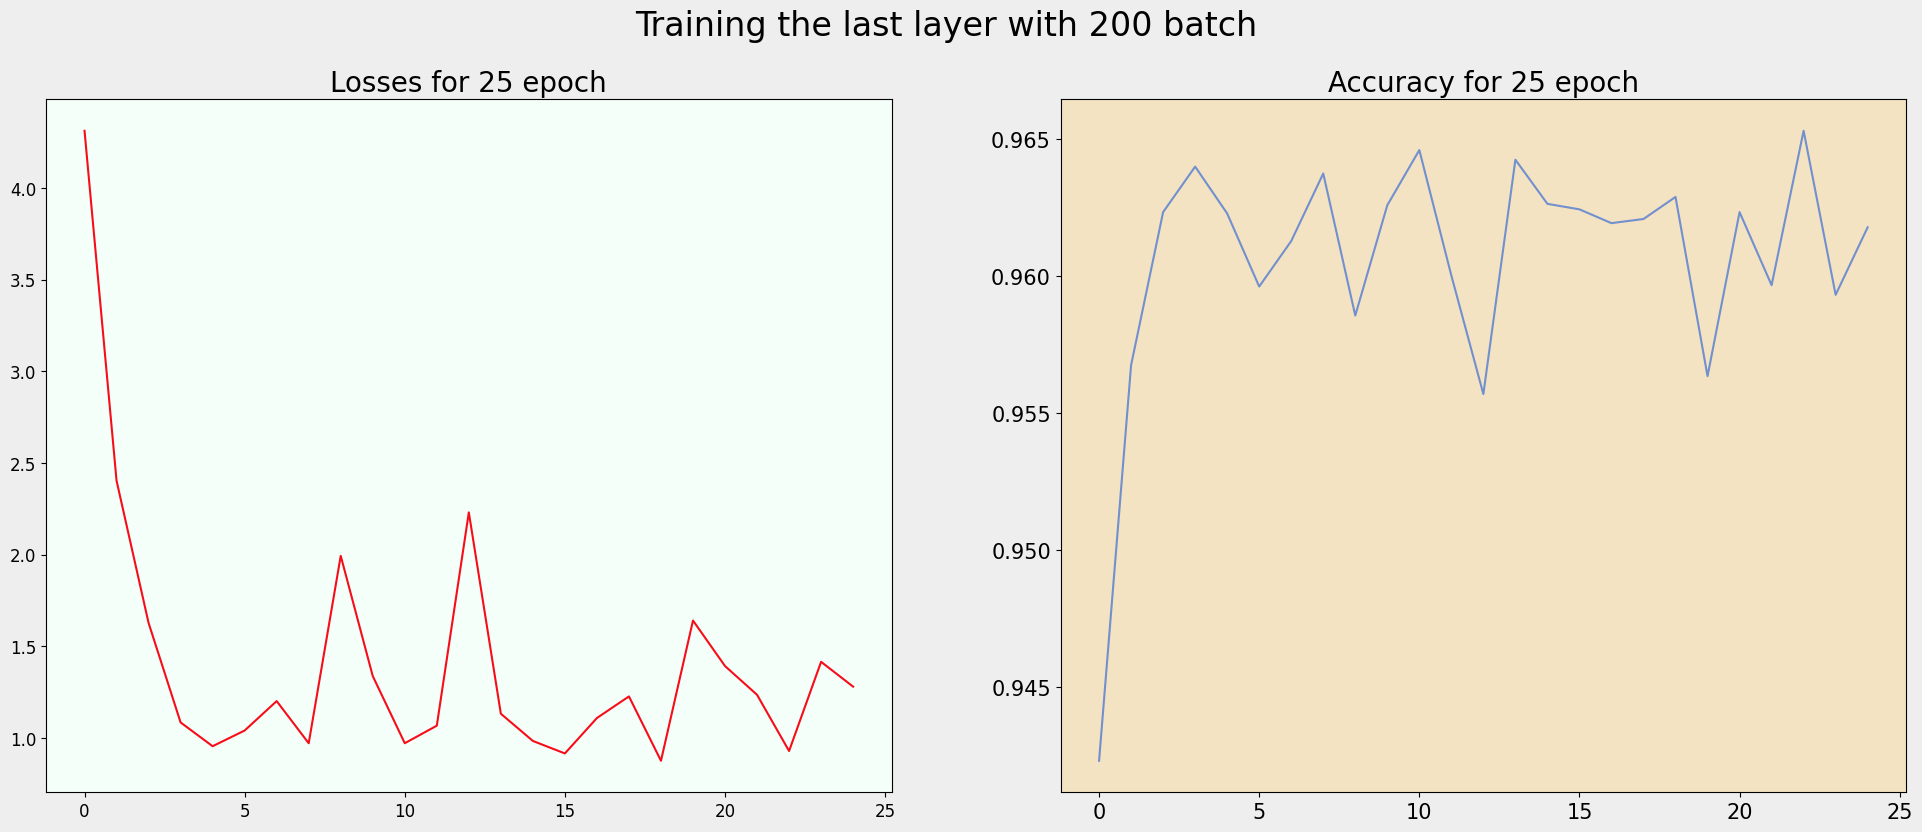

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
fig.set_facecolor("#EEEEEE")


ax1.plot(range(len(history.history['loss'])),history.history['loss'],color='#F70D1A',label='loss')
ax1.set_title("Losses for 25 epoch",fontdict={"size":20})
ax1.set_facecolor("#F5FFFA")
ax1.tick_params(axis='x', labelsize=12)  
ax1.tick_params(axis='y', labelsize=12)  

ax2.plot(range(len(history.history['accuracy'])),history.history['accuracy'],color='#728FCE',label='accuracy')
ax2.set_title("Accuracy for 25 epoch",fontdict={"size":20})
ax2.set_facecolor("#F3E3C3")
ax2.tick_params(axis='x', labelsize=15)  
ax2.tick_params(axis='y', labelsize=15)  


plt.suptitle("Training the last layer with 200 batch",fontsize="24")

In [ ]:
new_model.save("trained_added_2_layer_2.h5")

/home/jeswin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction with the current model

In [ ]:
model = keras.models.load_model("trained_added_2_layer_2.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
model_evaluations = []
for data in test_dataset.take(20):
    predictions = model.evaluate(data[0],data[1])
    model_evaluations.append(predictions)

2024-03-05 19:22:41.720727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 60211600 bytes after encountering the first element of size 60211600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-05 19:22:41.888214: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


4/4 [==============================] - 1s 253ms/step - loss: 0.1825 - accuracy: 0.9900


In [ ]:
model_evaluations

[[4.242115020751953, 0.8299999833106995],
 [6.256643295288086, 0.7400000095367432],
 [0.31076306104660034, 0.9900000095367432],
 [0.3059253394603729, 0.9800000190734863],
 [1.2802265700884163e-06, 1.0],
 [0.055451203137636185, 0.9900000095367432],
 [0.8980341553688049, 0.9599999785423279],
 [0.16511687636375427, 0.9900000095367432],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.36814022064208984, 0.9700000286102295],
 [0.09179404377937317, 0.9900000095367432],
 [0.0005071605555713177, 1.0],
 [0.12417858839035034, 0.9900000095367432],
 [0.013795255683362484, 0.9900000095367432],
 [0.03105264902114868, 0.9900000095367432],
 [0.0046319616958498955, 1.0],
 [0.11231238394975662, 0.9900000095367432],
 [0.0, 1.0],
 [0.18251003324985504, 0.9900000095367432]]

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset.take(300),validation_data = valid_dataset.take(50),epochs = 25)

Epoch 1/25


2024-03-05 20:28:51.983014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-05 20:28:52.394162: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/300 [..............................] - ETA: 54:29 - loss: 6.9215 - accuracy: 0.7800

2024-03-05 20:28:57.350603: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f14e1119760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 20:28:57.350619: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1709650737.390151    3411 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 104s 311ms/step - loss: 1.1061 - accuracy: 0.9616 - val_loss: 0.5147 - val_accuracy: 0.9728
Epoch 2/25
300/300 [==============================] - 91s 292ms/step - loss: 1.0192 - accuracy: 0.9624 - val_loss: 1.4329 - val_accuracy: 0.9425
Epoch 3/25
 72/300 [======>.......................] - ETA: 58s - loss: 1.3165 - accuracy: 0.9612

2024-03-05 20:32:23.023984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 92s 294ms/step - loss: 1.3102 - accuracy: 0.9621 - val_loss: 1.2444 - val_accuracy: 0.9470
Epoch 4/25
300/300 [==============================] - 92s 295ms/step - loss: 1.0138 - accuracy: 0.9589 - val_loss: 3.8208 - val_accuracy: 0.8978
Epoch 5/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.5562 - accuracy: 0.9598

2024-03-05 20:35:26.926633: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 93s 297ms/step - loss: 1.1191 - accuracy: 0.9622 - val_loss: 0.4972 - val_accuracy: 0.9712
Epoch 6/25
 72/300 [======>.......................] - ETA: 59s - loss: 0.8744 - accuracy: 0.9632

2024-03-05 20:36:59.727669: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 93s 299ms/step - loss: 0.9089 - accuracy: 0.9634 - val_loss: 0.8044 - val_accuracy: 0.9631
Epoch 7/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.1059 - accuracy: 0.9596

2024-03-05 20:38:32.937628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 300ms/step - loss: 0.9418 - accuracy: 0.9617 - val_loss: 0.7813 - val_accuracy: 0.9673
Epoch 8/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.8569 - accuracy: 0.9528

2024-03-05 20:40:06.633107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 301ms/step - loss: 1.1723 - accuracy: 0.9607 - val_loss: 0.5819 - val_accuracy: 0.9679
Epoch 9/25
 72/300 [======>.......................] - ETA: 59s - loss: 0.9123 - accuracy: 0.9608

2024-03-05 20:41:40.398590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 301ms/step - loss: 0.9851 - accuracy: 0.9642 - val_loss: 0.4948 - val_accuracy: 0.9728
Epoch 10/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.6803 - accuracy: 0.9520 

2024-03-05 20:43:14.229050: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.8484 - accuracy: 0.9566 - val_loss: 0.9419 - val_accuracy: 0.9665
Epoch 11/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.7567 - accuracy: 0.9539

2024-03-05 20:44:48.523105: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.5354 - accuracy: 0.9593 - val_loss: 0.7603 - val_accuracy: 0.9702
Epoch 12/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.3971 - accuracy: 0.9579

2024-03-05 20:46:22.631697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.4264 - accuracy: 0.9624 - val_loss: 1.2498 - val_accuracy: 0.9454
Epoch 13/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.3133 - accuracy: 0.9565

2024-03-05 20:47:56.885034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.6953 - accuracy: 0.9575 - val_loss: 2.9391 - val_accuracy: 0.9192
Epoch 14/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.2527 - accuracy: 0.9649

2024-03-05 20:49:31.028500: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 0.9529 - accuracy: 0.9640 - val_loss: 0.5544 - val_accuracy: 0.9688
Epoch 15/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 0.9924 - accuracy: 0.9577

2024-03-05 20:51:05.255605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 303ms/step - loss: 1.4921 - accuracy: 0.9585 - val_loss: 0.9793 - val_accuracy: 0.9663
Epoch 16/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.3489 - accuracy: 0.9601

2024-03-05 20:52:39.728749: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 95s 304ms/step - loss: 1.0776 - accuracy: 0.9636 - val_loss: 0.6642 - val_accuracy: 0.9631
Epoch 17/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 0.8096 - accuracy: 0.9635

2024-03-05 20:54:14.718230: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 95s 304ms/step - loss: 1.5276 - accuracy: 0.9588 - val_loss: 0.7202 - val_accuracy: 0.9696
Epoch 18/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.4349 - accuracy: 0.9569

2024-03-05 20:55:49.522100: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 95s 303ms/step - loss: 1.2504 - accuracy: 0.9610 - val_loss: 1.1588 - val_accuracy: 0.9530
Epoch 19/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.4331 - accuracy: 0.9579

2024-03-05 20:57:24.068211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 303ms/step - loss: 1.5453 - accuracy: 0.9593 - val_loss: 1.1857 - val_accuracy: 0.9609
Epoch 20/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.1663 - accuracy: 0.9652

2024-03-05 20:58:58.396328: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 303ms/step - loss: 1.1874 - accuracy: 0.9621 - val_loss: 1.2645 - val_accuracy: 0.9506
Epoch 21/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.1431 - accuracy: 0.9604

2024-03-05 21:00:32.794143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.3630 - accuracy: 0.9592 - val_loss: 0.7631 - val_accuracy: 0.9716
Epoch 22/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.4557 - accuracy: 0.9598

2024-03-05 21:02:07.133432: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 303ms/step - loss: 1.0762 - accuracy: 0.9632 - val_loss: 0.8998 - val_accuracy: 0.9571
Epoch 23/25
 72/300 [======>.......................] - ETA: 1:00 - loss: 1.3890 - accuracy: 0.9575

2024-03-05 21:03:41.517711: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 95s 303ms/step - loss: 1.0903 - accuracy: 0.9593 - val_loss: 0.7136 - val_accuracy: 0.9679
Epoch 24/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.1661 - accuracy: 0.9628 

2024-03-05 21:05:15.924846: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 301ms/step - loss: 1.8468 - accuracy: 0.9587 - val_loss: 0.7659 - val_accuracy: 0.9724
Epoch 25/25
 72/300 [======>.......................] - ETA: 59s - loss: 1.8051 - accuracy: 0.9575 

2024-03-05 21:06:49.829744: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


300/300 [==============================] - 94s 302ms/step - loss: 1.3126 - accuracy: 0.9614 - val_loss: 0.7452 - val_accuracy: 0.9649


In [ ]:
history.history

{'loss': [1.1060638427734375,
  1.019156575202942,
  1.3101906776428223,
  1.013810396194458,
  1.1190625429153442,
  0.9089459776878357,
  0.9418127536773682,
  1.172267198562622,
  0.9850637912750244,
  1.8483610153198242,
  1.5353504419326782,
  1.4264235496520996,
  1.6953458786010742,
  0.9528512358665466,
  1.4921103715896606,
  1.0775688886642456,
  1.5275996923446655,
  1.2504221200942993,
  1.545344591140747,
  1.1874024868011475,
  1.3629875183105469,
  1.0761933326721191,
  1.0903321504592896,
  1.8468129634857178,
  1.312568187713623],
 'accuracy': [0.9616182446479797,
  0.9623544216156006,
  0.9621201753616333,
  0.9589412212371826,
  0.9622206091880798,
  0.9633583426475525,
  0.9616851806640625,
  0.9606813192367554,
  0.9641613960266113,
  0.9566323161125183,
  0.9592758417129517,
  0.9624213576316833,
  0.9575358033180237,
  0.9639940857887268,
  0.9585062265396118,
  0.963592529296875,
  0.9588408470153809,
  0.9610159397125244,
  0.9593427777290344,
  0.9620532989501

Text(0.5, 0.98, 'Training the Pretrained model with 200 batch')

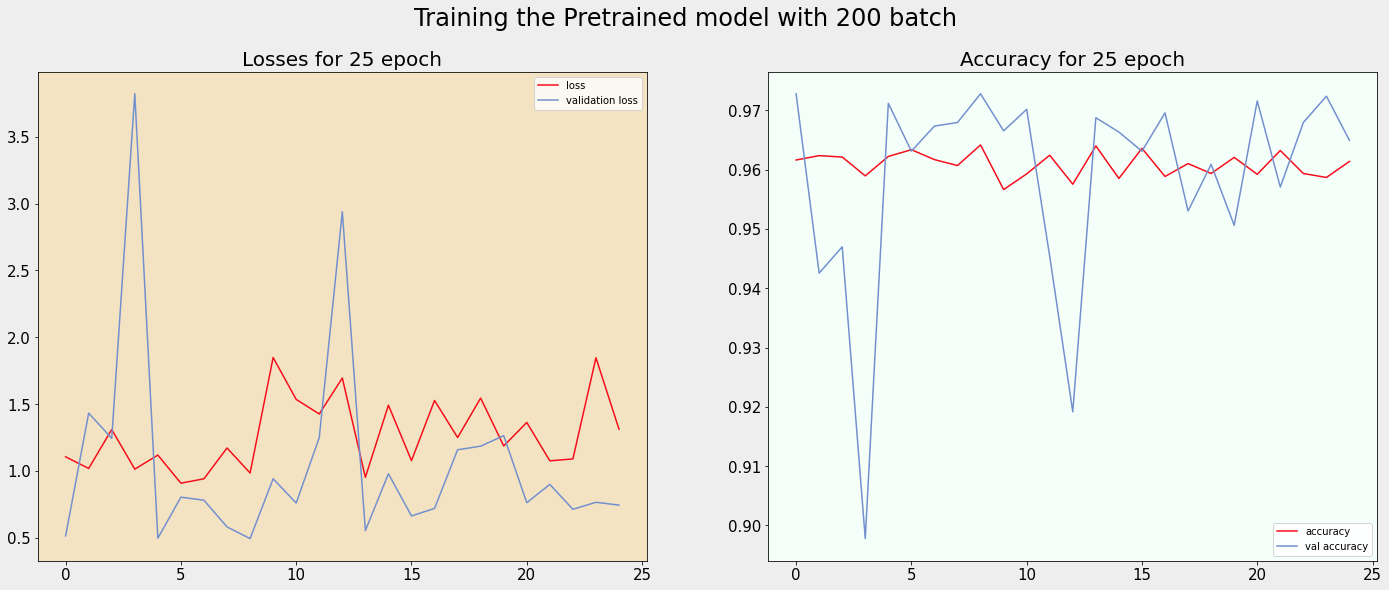

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
fig.set_facecolor("#EEEEEE")


ax1.plot(range(len(history.history['loss'])),history.history['loss'],color='#F70D1A',label='loss')
ax1.set_title("Losses for 25 epoch",fontdict={"size":20})
ax1.set_facecolor("#F3E3C3")
ax1.tick_params(axis='x', labelsize=15)  
ax1.tick_params(axis='y', labelsize=15)  

ax1.plot(range(len(history.history['val_loss'])),history.history['val_loss'],color='#728FCE',label='validation loss')
ax1.legend()

ax2.plot(range(len(history.history['accuracy'])),history.history['accuracy'],color='#F70D1A',label='accuracy')
ax2.set_title("Accuracy for 25 epoch",fontdict={"size":20})
ax2.set_facecolor("#F5FFFA")
ax2.tick_params(axis='x', labelsize=15)  
ax2.tick_params(axis='y', labelsize=15)  

ax2.plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'],color='#728FCE',label='val accuracy')
ax2.legend()
plt.suptitle("Training the Pretrained model with 200 batch",fontsize="24")

In [ ]:
file = open("final_open.txt","w")
file.write(str(history.history))
file.close()

In [ ]:
model.save("trained_2_final.h5")

/home/jeswin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
final_model = keras.models.load_model("trained_2_final.h5")
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [20]:
model_evaluations_2 = []
for data in test_dataset:
    predictions = final_model.evaluate(data[0],data[1])
    model_evaluations_2.append(predictions)

2024-03-06 11:57:44.168274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 78643600 bytes after encountering the first element of size 78643600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 [==============================] - 1s 813ms/step - loss: 0.6575 - accuracy: 0.9697


In [21]:
model_evaluations_2

[[4.637735366821289, 0.8100000023841858],
 [5.737094879150391, 0.800000011920929],
 [0.592888355255127, 0.9800000190734863],
 [0.0008383789681829512, 1.0],
 [0.452569842338562, 0.9900000095367432],
 [0.29348552227020264, 0.9900000095367432],
 [0.3359145224094391, 0.9800000190734863],
 [0.28226563334465027, 0.9800000190734863],
 [1.0687546730041504, 0.9700000286102295],
 [0.145894855260849, 0.9800000190734863],
 [0.14647150039672852, 0.9900000095367432],
 [0.22268058359622955, 0.9700000286102295],
 [0.0, 1.0],
 [0.09545233100652695, 0.9800000190734863],
 [0.10924619436264038, 0.9900000095367432],
 [0.2530214488506317, 0.9800000190734863],
 [0.47425612807273865, 0.9800000190734863],
 [2.3245540603511472e-07, 1.0],
 [0.04379358887672424, 0.9900000095367432],
 [0.39665138721466064, 0.9599999785423279],
 [0.0, 1.0],
 [0.6574579477310181, 0.9696969985961914]]

In [22]:
np.array(list(map(lambda x : x[0],model_evaluations_2))).mean(),np.array(list(map(lambda x : x[1],model_evaluations_2))).mean()

(0.7248396986993704, 0.9677135104482825)

In [10]:
def separate_data_and_label(data,labels):
    return (data,labels)

test_data = test_dataset.map(separate_data_and_label)

In [16]:
test_x = list(map(lambda x : x[0],test_data))
test_y = list(map(lambda x : x[1],test_data))

In [28]:
predictions_list = []
labels_collection = []
for data in test_dataset:
    predictions = final_model.predict(data[0])
    predictions_list.extend(list(predictions))
    labels_collection.extend(list(map(lambda x : x.numpy(),data[1])))

2/2 [==============================] - 0s 340ms/step


In [29]:
predictions_label = list(map(lambda x : np.argmax(x),predictions_list))
predictions_label[:10]

[0, 1, 0, 1, 0, 0, 1, 1, 1, 0]

In [30]:
len(predictions_label),len(labels_collection)

(1988, 1988)

In [32]:
print(classification_report(labels_collection,predictions_label))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1509
           1       0.92      0.96      0.94       479

    accuracy                           0.97      1988
   macro avg       0.95      0.97      0.96      1988
weighted avg       0.97      0.97      0.97      1988



In [34]:
precision = precision_score(labels_collection,predictions_label)
recall = recall_score(labels_collection,predictions_label)
conf_matrix = confusion_matrix(labels_collection,predictions_label)
precision,recall

(0.9166666666666666, 0.964509394572025)

In [35]:
conf_matrix

array([[1467,   42],
       [  17,  462]])

In [41]:
f1_score = (2* (precision*recall))/(precision+recall)
f1_score

0.9399796541200407